#  RNN-LSTM et architectures avancées [Analyse de sentiment]

In [ ]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [ ]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt
import re
# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def affiche(history):
    # summarize history for accuracy
    plt.style.use("ggplot")
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 1. Charger les données

In [ ]:
import pandas as pd
#import os
#os.system("kaggle datasets download -d utathya/imdb-review-dataset")

# On lit le fichier csv de la base d'avis de IMDB (qui doit être préalablement être placé dans le dossier ./data/)
#data = pd.read_csv('./imdb_master.csv',encoding="latin-1")


In [ ]:
# On visualise les données brutes
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# On visualise le tableau de données (en utilisant les méthodes de data)
data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


## 2. Formater/Préparer les données

In [ ]:
# FORMATAGE DES DONNEES

# On supprimes les données sans label
data = data[data.label != 'unsup']
#data.head()
# On reformate les labels et entiers (pos = 0; neg = 1)
data['label'] = data['label'].map({'pos': 1, 'neg': 0})
# On supprime les champs inutiles
data = data.drop(['Unnamed: 0','file'],axis=1)

# On visualise le tableau de données
data.head()
data.to_csv("./resultat_tmp.csv", sep = ',')    # ---> OK

In [ ]:
# 2) FILTRER LES DONNEES
#
# Le nettoyage des données est une étape essentielle de pré-traitement pour optimiser l'apprentissage en aval
#
# Pour le texte, il s'agit de : 
# - normer le texte,  
# - segmenter le texte en mots 
# - supprimer les mots peu porteurs d'information
# - puis détermines les lemmes, de , etc...
#

# On importe la librarie nltk dédiée aux traitement du langage naturel
import nltk
import os.path
nltk.download('wordnet')
nltk.download('stopwords')

# On peut utiliser l'environnement nltk spécialisé pour le traitement de texte
# (WordNet, stopwords pré-appris sur des bases de données)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

# On pré-traite le texte pour normaliser le texte en entrée
# - On retire certains caractères spéciaux
# - On force la casse en minuscule
# - on retire tous les mots qui sont des "stop_words"
# - on lemmatise les mots (~les formes canoniques)
def preprocess_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

# On pré-traite les données et on les place dans le champs "Processed reviews"
if os.path.isfile(r"./resultat.csv") == True :
    data = pd.read_csv('./resultat.csv',encoding="latin-1")
else :
    data['Processed_Reviews'] = data.review.apply(lambda x: preprocess_text(x))
    
    data.to_csv("./resultat.csv", sep = ',')
    
# On visualise les données
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,type,review,label,Processed_Reviews
0,0,test,Once again Mr. Costner has dragged out a movie...,0,mr costner ha drag movie far longer necessary ...
1,1,test,This is an example of why the majority of acti...,0,example majority action film generic bore real...
2,2,test,"First of all I hate those moronic rappers, who...",0,first hate moronic rapper couldnt act gun pres...
3,3,test,Not even the Beatles could write songs everyon...,0,even beatles could write song everyone like al...
4,4,test,Brass pictures (movies is not a fitting word f...,0,brass picture movie fit word really somewhat b...


\s
For Unicode (str) patterns:
Matches Unicode whitespace characters (which includes [ \t\n\r\f\v], and also many other characters, for example the non-breaking spaces mandated by typography rules in many languages). If the ASCII flag is used, only [ \t\n\r\f\v] is matched.

\w
For Unicode (str) patterns:
Matches Unicode word characters; this includes most characters that can be part of a word in any language, as well as numbers and the underscore. If the ASCII flag is used, only [a-zA-Z0-9_] is matched.


In [ ]:
# On découpe les phrases en "mots"

from tensorflow.keras.preprocessing.text import Tokenizer

# On ne retient que les 5,000 tokens les plus fréquents (dans le texte)
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['Processed_Reviews'])

# On vectorise les mots


print("La phrase à encoder est : \n  {} \n" .format(data['Processed_Reviews'][0]))

# On vectorise les tokens en séquences numériques
list_tokenized_train = tokenizer.texts_to_sequences(data['Processed_Reviews']) # return a list of sequences 

print("La phrase vectorisée est : \n {} \n". format(list_tokenized_train[0]))

La phrase à encoder est : 
  mr costner ha drag movie far longer necessary aside terrific sea rescue sequence care character u ghost closet costners character realize early forget much later time care character really care cocky overconfident ashton kutcher problem come kid think better anyone else around show sign clutter closet obstacle appear win costner finally well past half way point stinker costner tell u kutchers ghost tell kutcher drive best prior inkling foreshadow magic wa could keep turn hour 

La phrase vectorisée est : 
 [334, 10, 981, 2, 143, 1042, 1556, 1047, 1217, 1435, 1437, 352, 282, 15, 91, 976, 3454, 15, 454, 337, 414, 24, 219, 11, 282, 15, 20, 282, 213, 39, 154, 19, 59, 173, 254, 104, 21, 1123, 3454, 263, 424, 342, 22, 445, 247, 37, 89, 3223, 84, 91, 976, 84, 492, 53, 2239, 1234, 3, 43, 119, 94, 246] 



In [ ]:
# On padde les séquences

from tensorflow.keras.preprocessing.sequence import pad_sequences
'''
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)
'''
# On padde les séquence de mot
max_len = 100
X       = pad_sequences(list_tokenized_train, maxlen=max_len)

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, X[0]))
      

La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  334   10  981
    2  143 1042 1556 1047 1217 1435 1437  352  282   15   91  976 3454
   15  454  337  414   24  219   11  282   15   20  282  213   39  154
   19   59  173  254  104   21 1123 3454  263  424  342   22  445  247
   37   89 3223   84   91  976   84  492   53 2239 1234    3   43  119
   94  246]


In [ ]:
# On crée les ensembles d'apprentissage et de test

# On récupère les données correspondantes aux séquences de mots
y       = data['label']
typ     = data['type']

# Indexes des données pour l'entrainement et le test (tels que spécifiés dans data)
i_trn  = [i for i in range(len(typ)) if typ[i]=='train']
i_tst  = [i for i in range(len(typ)) if typ[i]=='test']

# Données d'entrée
X_trn = X[i_trn]
X_tst = X[i_tst]
# Labels de sorties
y_trn = y[i_trn]
y_tst = y[i_tst]

## 3. Déclaration du réseau

In [ ]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout , Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:


embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# On définit l'architecture du réseau
model = Sequential()
model.add(Embedding(max_features, embed_size))                     # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))           # layer RNN
model.add(Dropout(0.5))                                            # layer Dropout
model.add(Dense(1))                                                # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Questions : 
# 1) Pourquoi introduit entre l'entrée et le RNN une couche d'embedding? A quoi cela sert-il?
# 2) Réaliser le schéma du réseau proposé en précisant le dimensions d'entrée et de sortie de chaque couche
# 3) Pourquoi utilise-t-on le RNN avec l'option return_sequences = False ?
# 4) Pourquoi introduit-on du Dropout?


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [ ]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 20                                                                   # nombre d'époques
history = model.fit(X_trn,y_trn, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/20
313/313 [==============================] - 14s 45ms/step - loss: 1.9131 - accuracy: 0.5758 - val_loss: 1.0752 - val_accuracy: 0.2666
Epoch 2/20
313/313 [==============================] - 13s 43ms/step - loss: 0.8731 - accuracy: 0.7028 - val_loss: 4.6110 - val_accuracy: 0.0660
Epoch 3/20
313/313 [==============================] - 13s 43ms/step - loss: 1.6829 - accuracy: 0.6446 - val_loss: 2.3637 - val_accuracy: 0.1354
Epoch 4/20
313/313 [==============================] - 14s 43ms/step - loss: 3.1217 - accuracy: 0.5918 - val_loss: 1.6795 - val_accuracy: 0.0492
Epoch 5/20
313/313 [==============================] - 14s 44ms/step - loss: 2.3651 - accuracy: 0.6117 - val_loss: 1.6212 - val_accuracy: 0.2854
Epoch 6/20
313/313 [==============================] - 13s 43ms/step - loss: 3.0134 - accuracy: 0.5979 - val_loss: 2.4896 - val_accuracy: 0.1186
Epoch 7/20
313/313 [==============================] - 13s 43ms/step - loss: 2.6328 - accuracy: 0.6177 - val_loss: 10.8035 - val_accuracy

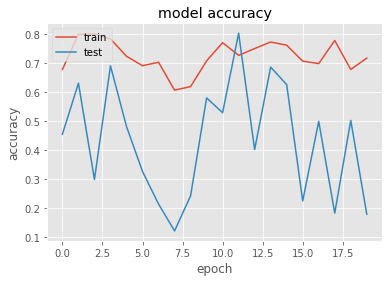

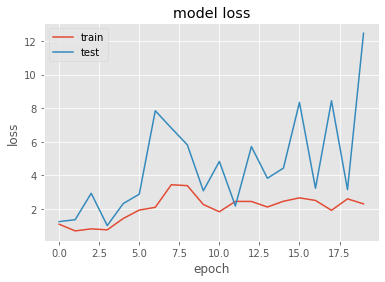

In [ ]:
affiche(history)

In [ ]:
# On prédit sur l'ensemble de test

# On prédit sur les données de test
y_hat = model.predict(X_tst)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

y_pred   = np.zeros(len(y_hat))
y_pred[i_pos] = 1
y_pred[i_neg] = 0


In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

In [ ]:


# On calcule la matrice de confusion
cm_test = confusion_matrix(y_tst, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_tst, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 1946 10554]
 [ 1604 10896]] 

L accuracy sur le jeu de test est :
 0.51368


In [ ]:
# Questions : 
# 1) Commenter cette performance. Est-ce satisfaisant? Pourquoi?
# 2) Implémenter le même réseau en changeant la couche RNN par une couche LSTM, puis une couche LSTM bi-directionnelle
# avec le même nombre de neurones. 
# Expliquer la différence entre ces deux couches. 
# Discuter les performances obtenues.
# 3) Implémenter un réseau avec deux couches LSTM, l'une avec 64 neurones la seconde avec 32 neurones. 
# Dans cette configuration, quelles seront les valeurs de return_sequence pour chacune des couches?
# Commenter la performance obtenue
# 4) Ajouter en sortie du second LSTM une couche GlobalMaxPool1D. A quoi cela sert-il? Mêmes questions que pour 3)
# 5) [BONUS] Remplacer cette dernière couche par une couche d'attention. Commenter la performance obtenue

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 32s 103ms/step - loss: 0.6882 - accuracy: 0.7086 - val_loss: 0.5200 - val_accuracy: 0.6610
Epoch 2/20
313/313 [==============================] - 31s 98ms/step - loss: 0.6472 - accuracy: 0.7079

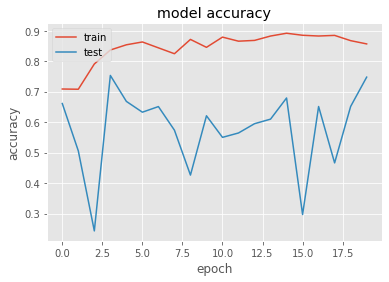

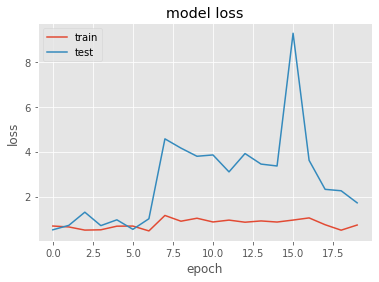

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
LSTM_size   = 64

# On définit l'architecture du réseau
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(max_features, embed_size))                     # layer embedding
model_LSTM_1.add(LSTM(LSTM_size, return_sequences = False, activation = 'relu'))           # layer RNN
model_LSTM_1.add(Dropout(0.5))                                            # layer Dropout
model_LSTM_1.add(Dense(1))                                                # layer Dense

# On affiche l'architecture de notre modèle
model_LSTM_1.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_LSTM_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 20                                                                # nombre d'époques
history_2 = model_LSTM_1.fit(X_trn,y_trn, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

affiche(history_2)

In [ ]:
# On prédit sur les données de test
y_hat_LSTM_1 = model_LSTM_1.predict(X_tst)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat_LSTM_1[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat_LSTM_1[i]<=0]

y_pred_LSTM_1   = np.zeros(len(y_hat_LSTM_1))
y_pred_LSTM_1[i_pos] = 1
y_pred_LSTM_1[i_neg] = 0

# On calcule la matrice de confusion
cm_test_LSTM_1 = confusion_matrix(y_tst, y_pred_LSTM_1)
print('La matrice de confusion sur le jeu de test :\n', cm_test_LSTM_1, '\n')

# On calcul le score d accuracy
acc_train_LSTM_1=accuracy_score(y_tst, y_pred_LSTM_1)
print('L accuracy sur le jeu de test est :\n', acc_train_LSTM_1)


La matrice de confusion sur le jeu de test :
 [[ 7123  5377]
 [ 1049 11451]] 

L accuracy sur le jeu de test est :
 0.74296


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
313/313 [==============================] - 134s 428ms/step - loss: 0.6260 - accuracy: 0.7092 - val_loss: 1.0926 - val_accuracy: 0.6398
Epoch 2/10
313/313 [==============================] - 132s 423ms/step - loss: 0.5289 - accuracy: 0.7

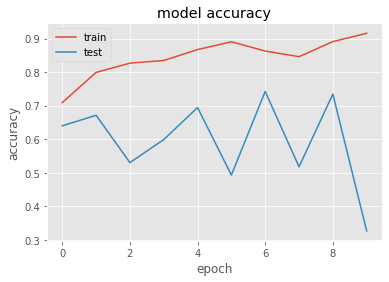

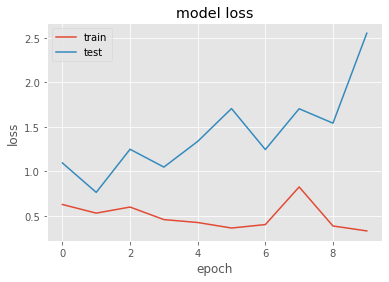

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
LSTM_size   = 64

# On définit l'architecture du réseau
model_LSTM_2 = Sequential()
model_LSTM_2.add(Embedding(max_features, embed_size))                     # layer embedding
model_LSTM_2.add(Bidirectional(layer=LSTM(LSTM_size, return_sequences = False, dropout=0.2, recurrent_dropout=0.2),merge_mode="concat", weights=None, backward_layer=None))          # layer RNN
model_LSTM_2.add(Dropout(0.8))                                            # layer Dropout
model_LSTM_2.add(Dense(1))                                                # layer Dense

# On affiche l'architecture de notre modèle
model_LSTM_2.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_LSTM_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_3 = model_LSTM_2.fit(X_trn,y_trn, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

affiche(history_3)

In [ ]:
# On prédit sur les données de test
y_hat_LSTM_2 = model_LSTM_2.predict(X_tst)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat_LSTM_2[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat_LSTM_2[i]<=0]

y_pred_LSTM_2   = np.zeros(len(y_hat_LSTM_2))
y_pred_LSTM_2[i_pos] = 1
y_pred_LSTM_2[i_neg] = 0

# On calcule la matrice de confusion
cm_test_LSTM_2 = confusion_matrix(y_tst, y_pred_LSTM_2)
print('La matrice de confusion sur le jeu de test :\n', cm_test_LSTM_2, '\n')

# On calcul le score d accuracy
acc_train_LSTM_2=accuracy_score(y_tst, y_pred_LSTM_2)
print('L accuracy sur le jeu de test est :\n', acc_train_LSTM_2)

La matrice de confusion sur le jeu de test :
 [[ 6223  6277]
 [ 1108 11392]] 

L accuracy sur le jeu de test est :
 0.7046


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 701,857
Trainable params: 701,857
Non-trainable params: 0
________________________________________________

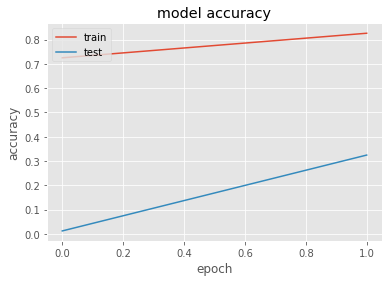

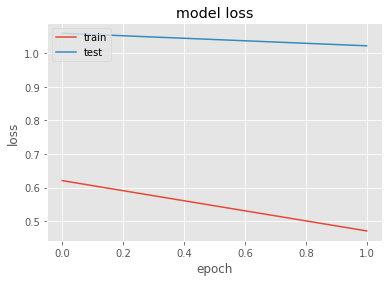

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
LSTM_size   = 64

# On définit l'architecture du réseau


# On affiche l'architecture de notre modèle
model_LSTM_3.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_LSTM_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 2                                                             # nombre d'époques
history_4 = model_LSTM_3.fit(X_trn,y_trn, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

affiche(history_4)

In [ ]:
# On prédit sur les données de test
y_hat_LSTM_3 = model_LSTM_3.predict(X_tst)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat_LSTM_3[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat_LSTM_3[i]<=0]

y_pred_LSTM_3   = np.zeros(len(y_hat_LSTM_3))
y_pred_LSTM_3[i_pos] = 1
y_pred_LSTM_3[i_neg] = 0

# On calcule la matrice de confusion
cm_test_LSTM_3 = confusion_matrix(y_tst, y_pred_LSTM_3)
print('La matrice de confusion sur le jeu de test :\n', cm_test_LSTM_3, '\n')

# On calcul le score d accuracy
acc_train_LSTM_3=accuracy_score(y_tst, y_pred_LSTM_3)
print('L accuracy sur le jeu de test est :\n', acc_train_LSTM_3)

La matrice de confusion sur le jeu de test :
 [[ 4481  8019]
 [  231 12269]] 

L accuracy sur le jeu de test est :
 0.67


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
lstm_25 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_26 (LSTM)               (None, None, 32)          12416     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 701,857
Trainable params: 701,857
Non-trainable params: 0
_______________________________________________

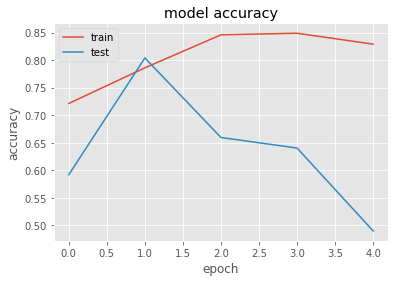

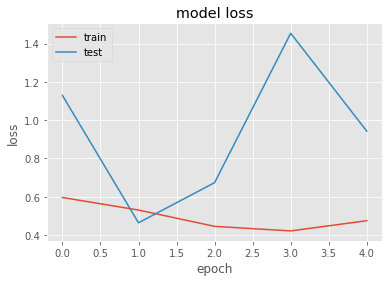

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
LSTM_size   = 64

# On définit l'architecture du réseau
model_LSTM_4 = Sequential()
model_LSTM_4.add(Embedding(max_features, embed_size))                     # layer embedding
model_LSTM_4.add(LSTM(LSTM_size, return_sequences = True))           # layer RNN
model_LSTM_4.add(LSTM(32, return_sequences = True))
model_LSTM_4.add(GlobalMaxPool1D())
model_LSTM_4.add(Dropout(0.5))                                            # layer Dropout
model_LSTM_4.add(Dense(1))                                                # layer Dense

# On affiche l'architecture de notre modèle
model_LSTM_4.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_LSTM_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 5                                                            # nombre d'époques
history_5 = model_LSTM_4.fit(X_trn,y_trn, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

affiche(history_5)

In [ ]:
# On prédit sur les données de test
y_hat_LSTM_4 = model_LSTM_4.predict(X_tst)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat_LSTM_4[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat_LSTM_4[i]<=0]

y_pred_LSTM_4   = np.zeros(len(y_hat_LSTM_4))
y_pred_LSTM_4[i_pos] = 1
y_pred_LSTM_4[i_neg] = 0

# On calcule la matrice de confusion
cm_test_LSTM_4 = confusion_matrix(y_tst, y_pred_LSTM_3)
print('La matrice de confusion sur le jeu de test :\n', cm_test_LSTM_3, '\n')

# On calcul le score d accuracy
acc_train_LSTM_4=accuracy_score(y_tst, y_pred_LSTM_4)
print('L accuracy sur le jeu de test est :\n', acc_train_LSTM_4)

La matrice de confusion sur le jeu de test :
 [[ 3224  9276]
 [   81 12419]] 

L accuracy sur le jeu de test est :
 0.6412
